# 1. Deep Learning Setup and Data Preparation

In this section, the UNSW-NB15 training and test sets are loaded and prepared 
for deep learning models. The binary attack/normal label is created in a 
consistent format, identifier-related fields (e.g., flow ID, IP addresses, and 
port numbers) are removed to avoid data leakage, and basic cleaning is applied 
to text-based columns.

Afterwards, feature engineering is applied by introducing the `byte_ratio` 
feature to capture proportional differences between source and destination byte 
volumes. Finally, all features are transformed into dense numerical matrices 
(`X_tr`, `X_te`) using a unified preprocessing pipeline suitable for both MLP 
and Autoencoder models.


In [1]:
# Let's load our necessary libraries.
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



RANDOM_SEED = 42 # Let's get randomness under control.
np.random.seed(RANDOM_SEED)


PROJECT_ROOT = Path(".")
train_path = PROJECT_ROOT / "UNSW_NB15_training-set.csv"
test_path  = PROJECT_ROOT / "UNSW_NB15_testing-set.csv"

print("Train CSV:", train_path.resolve())
print("Test  CSV:", test_path.resolve())


Train CSV: /Users/cansenol/Desktop/THESIS/UNSW_NB15/OneDrive_1_06.10.2025/CSV Files/Training and Testing Sets/UNSW_NB15_training-set.csv
Test  CSV: /Users/cansenol/Desktop/THESIS/UNSW_NB15/OneDrive_1_06.10.2025/CSV Files/Training and Testing Sets/UNSW_NB15_testing-set.csv


In [2]:
# We load our datasets 
df_train = pd.read_csv(train_path, low_memory=False)
df_test  = pd.read_csv(test_path, low_memory=False)
print("Raw train shape:", df_train.shape)
print("Raw test  shape:", df_test.shape)

Raw train shape: (175341, 45)
Raw test  shape: (82332, 45)


In [3]:
# We create our Label column with our build_label function
def build_label(df):
    # However, if there is no 'label', let's generate 0/1 labels via 'attack_cat'
    if "label" not in df.columns:
        df = df.copy()
        df["attack_cat"] = (
            df["attack_cat"]
            .fillna("Normal")
            .astype(str)
            .str.strip()
        )
        df["label"] = (df["attack_cat"] != "Normal").astype(int)
    else:
        df = df.copy()
        df["label"] = df["label"].astype(int)
    return df

df_train = build_label(df_train)
df_test  = build_label(df_test)

print(df_train["label"].value_counts())
print(df_test["label"].value_counts())


label
1    119341
0     56000
Name: count, dtype: int64
label
1    45332
0    37000
Name: count, dtype: int64


In [4]:
# We need to clean up unnecessary spaces in Object type columns.
for df in (df_train, df_test):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()

In [5]:
# Let's convert texts that look like numbers into numbers!
keep_text = ["proto", "service", "state", "attack_cat"]

for df in (df_train, df_test):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        
        if c in keep_text:
            continue  # Bu kategorik olarak kalmalı
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().sum() >= 0.5 * len(df):
            df[c] = coerced

In [6]:
# We must remove columns that may create data leaks!
LEAKAGE_COLS = ["id", "srcip", "dstip", "sport", "dsport", "attack_cat"]

for name, df in [("train", df_train), ("test", df_test)]:
    cols_to_drop = [c for c in LEAKAGE_COLS if c in df.columns]
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"{name} removed:", cols_to_drop)

print("After cleaning train:", df_train.shape)
print("After cleaning test :", df_test.shape)

train removed: ['id', 'attack_cat']
test removed: ['id', 'attack_cat']
After cleaning train: (175341, 43)
After cleaning test : (82332, 43)


In [7]:
# Feature engineering: We add source/target byte ratio.
for df in (df_train, df_test):
    if {"sbytes", "dbytes"}.issubset(df.columns):
        df["byte_ratio"] = (df["sbytes"] + 1) / (df["dbytes"] + 1)


print("byte_ratio added.")

byte_ratio added.


In [8]:
# We create X_tr and X_te for deep learning here.


drop_cols = [c for c in LEAKAGE_COLS + ["label"] if c in df_train.columns]

X_tr_raw = df_train.drop(columns=drop_cols)
y_tr = df_train["label"].astype("int32").values

X_te_raw = df_test.drop(columns=drop_cols)
y_te = df_test["label"].astype("int32").values

print("X_tr_raw:", X_tr_raw.shape)
print("X_te_raw:", X_te_raw.shape)

# Let's create a list of numeric and categorical columns.
num_cols = X_tr_raw.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_tr_raw.columns if c not in num_cols]

X_tr_raw: (175341, 43)
X_te_raw: (82332, 43)


In [9]:
# Let's do our preprocessing operations.


# Let's fill the empty numeric columns with the median and scale them...
numeric = Pipeline([
    ("impute", SimpleImputer(strategy="median")),  
    ("scale", StandardScaler(with_mean=True)),
])

# Let's fill in the categorical columns with most_frequent. That is, let's take the most used one.
categor = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),  
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])



pre = ColumnTransformer(
    [
        ("num", numeric, num_cols),
        ("cat", categor, cat_cols),
    ],
    sparse_threshold=0.0,
)

# Let's transform our train and test data.
X_tr = pre.fit_transform(X_tr_raw).astype("float32")
X_te = pre.transform(X_te_raw).astype("float32")

print("X_tr:", X_tr.shape)
print("X_te:", X_te.shape)
print("Data preparation completed.")


X_tr: (175341, 195)
X_te: (82332, 195)
Data preparation completed.


# 2. Multilayer Perceptron (MLP) Implementation:

In this section, a feed-forward Multi-Layer Perceptron (MLP) is trained as a 
supervised binary classifier using the dense feature matrices prepared in 
Section 1. The model follows a typical deep learning architecture composed of 
fully connected layers with ReLU activation, batch normalization, and dropout 
regularization. The objective is to learn a non-linear decision function that 
distinguishes attack flows from normal traffic.

The training process uses the Adam optimizer and binary cross-entropy loss, 
together with accuracy and AUC as evaluation metrics. Validation metrics are 
monitored to observe overfitting behavior, and training curves (loss, accuracy, 
AUC) are visualized at the end of this section.


In [10]:
import tensorflow as tf

try:
    tf.config.set_visible_devices([], "GPU")  
except Exception as e:
    print("GPU config warning:", e)


In [11]:
# Before we begin, we need to install the Keras and TensorFlow libraries.
from tensorflow import keras
from tensorflow.keras import layers

# Randomization adjustment for consistency of training outcomes!
tf.random.set_seed(RANDOM_SEED)

In [12]:
# 2.2 MLP model mimarisi tanımlanıyor

def build_mlp(input_dim):
    
   
    model = keras.Sequential([
        
        
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.BatchNormalization(),   
        layers.Dropout(0.3),          
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1, activation="sigmoid")
    ])
    

# Let's compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return model

# Let's create the model.
mlp = build_mlp(X_tr.shape[1])
mlp.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,353 (142.00 KB)

 Trainable params: 35,905 (140.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# We are training the model...


history = mlp.fit(
    X_tr, y_tr,
    validation_split=0.2,      # 20% of the training set is used as validation
    epochs=20,                
    batch_size=256,           # Large batches ensure fast and stable training!
    verbose=1
)

Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9075 - auc: 0.9688 - loss: 0.2025 - val_accuracy: 0.9936 - val_auc: 0.0000e+00 - val_loss: 0.0447
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9215 - auc: 0.9807 - loss: 0.1577 - val_accuracy: 0.9938 - val_auc: 0.0000e+00 - val_loss: 0.0427
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9227 - auc: 0.9822 - loss: 0.1514 - val_accuracy: 0.9931 - val_auc: 0.0000e+00 - val_loss: 0.0422
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9239 - auc: 0.9830 - loss: 0.1484 - val_accuracy: 0.9921 - val_auc: 0.0000e+00 - val_loss: 0.0410
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9249 - auc: 0.9836 - loss: 0.1460 - val_accuracy: 0.9916 - val_auc: 0.0000e+00 - val_loss: 0.0370
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9257 - auc: 0.9841 - loss: 0.1444 - val_accuracy: 0.9894 - val_auc: 0.0000e+00 - val_loss: 0.0396
Epoch 7/20
548/5

In [14]:
# Let's evaluate the model on the test set...
y_pred_proba = mlp.predict(X_te)
y_pred = (y_pred_proba >= 0.5).astype(int).ravel()

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("MLP Classification Report:")
print(classification_report(y_te, y_pred))
print("MLP ROC-AUC:", roc_auc_score(y_te, y_pred_proba))
print("Confusion Matrix:")
print(confusion_matrix(y_te, y_pred))

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 225us/step
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     37000
           1       0.86      0.95      0.90     45332

    accuracy                           0.89     82332
   macro avg       0.89      0.88      0.88     82332
weighted avg       0.89      0.89      0.89     82332

MLP ROC-AUC: 0.9773008363521025
Confusion Matrix:
[[29831  7169]
 [ 2199 43133]]


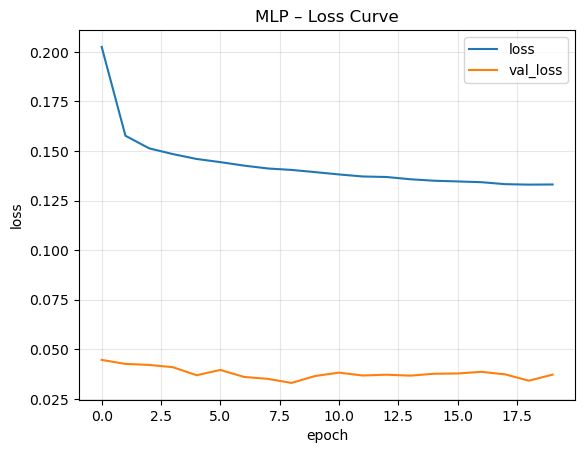

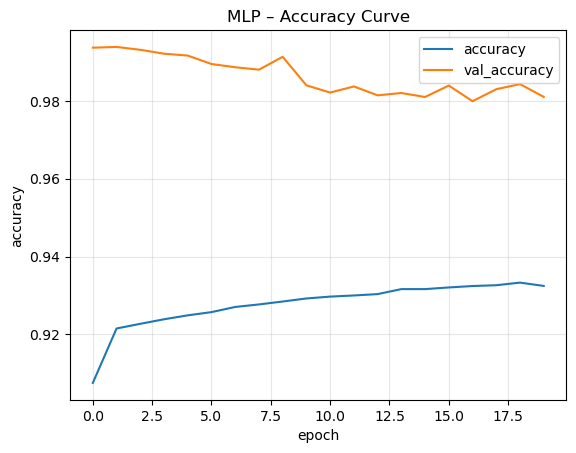

In [15]:

import matplotlib.pyplot as plt


# Let's draw metric graphs of the training process!

def plot_hist(h, key, title):
    plt.figure()
    plt.plot(h.history[key], label=key)
    vk = "val_" + key
    if vk in h.history:
        plt.plot(h.history[vk], label=vk)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(key)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_hist(history, "loss", "MLP – Loss Curve")
plot_hist(history, "accuracy", "MLP – Accuracy Curve")

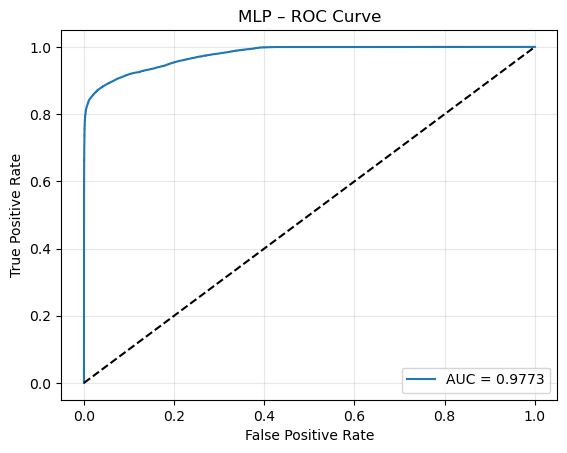

In [16]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP – ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Autoencoder Implementation

In this section, an unsupervised Autoencoder model is trained to learn the 
distribution of normal (benign) network traffic. The idea is that the model 
can accurately reconstruct benign flows but will struggle to reconstruct attack 
flows due to their different statistical patterns.

The Autoencoder consists of a symmetric encoder–decoder architecture with 
fully connected layers and ReLU activations. The model is trained only on the 
normal samples from the training set, and reconstruction error is later used as 
an anomaly score. High reconstruction error indicates that the input flow 
differs from benign traffic characteristics and is therefore likely to be an 
attack.

After training, reconstruction errors are computed for both benign and attack 
samples in the test set. The ROC curve and AUC score provide an evaluation of 
how well the Autoencoder separates the two classes based on reconstruction 
error.


In [18]:
# Since the autoencoder will be trained only on normal traffic, we must select normal flows in the training set (label = 0)
X_tr_normal = X_tr[y_tr == 0]

print("Normal training samples:", X_tr_normal.shape)

Normal training samples: (56000, 195)


In [19]:
# Autoencoder model architecture


def build_autoencoder(input_dim):
    
    # Our Encoder part.
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    
 
    latent = layers.Dense(64, activation="relu")(x)
    
    # Decoder part...
    x = layers.Dense(128, activation="relu")(latent)
    x = layers.BatchNormalization()(x)
    
    # Reconstruction output..
    out = layers.Dense(input_dim, activation="linear")(x)
    
    model = keras.Model(inp, out)
    
    model.compile(
        optimizer="adam",
        loss="mse"   # Reconstruction-based training
    )
    
    return model
    

ae = build_autoencoder(X_tr.shape[1])
ae.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 195)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 195)            │        25,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,843 (265.01 KB)

 Trainable params: 67,331 (263.01 KB)

 Non-trainable params: 512 (2.00 KB)

In [20]:
# Let's train our autoencoder model!
history_ae = ae.fit(
    
    X_tr_normal, X_tr_normal,   # Reconstruction learning
    epochs=20,
    batch_size=256,
    
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1141 - val_loss: 0.2384
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - val_loss: 0.0989
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0769
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0658
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0583
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0536
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0495
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0459
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0422
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0395
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0376
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [21]:
# Reconstruction error calculation. MSE difference between autoencoder output and input (anomaly score)
reconstructed = ae.predict(X_te)
reconstruction_error = np.mean((X_te - reconstructed)**2, axis=1)
print("Example reconstruction errors:", reconstruction_error[:5])

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step
Example reconstruction errors: [0.00068125 0.00158773 0.00098922 0.0007796  0.00263918]


Autoencoder ROC-AUC: 0.8230869581418532


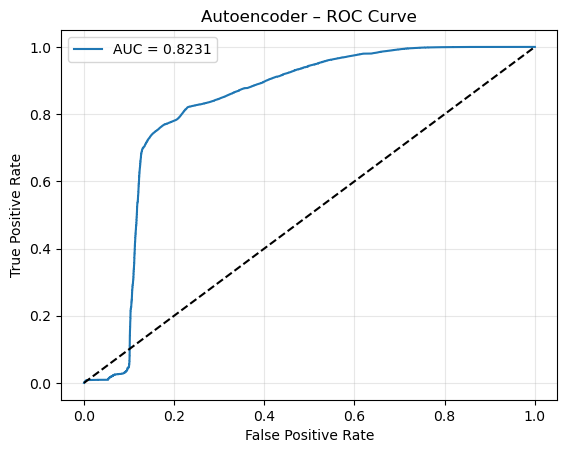

In [22]:
# Let's evaluate model performance with ROC and AUC!

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_te, reconstruction_error)
roc_auc_ae = auc(fpr, tpr)
print("Autoencoder ROC-AUC:", roc_auc_ae)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_ae:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Autoencoder – ROC Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

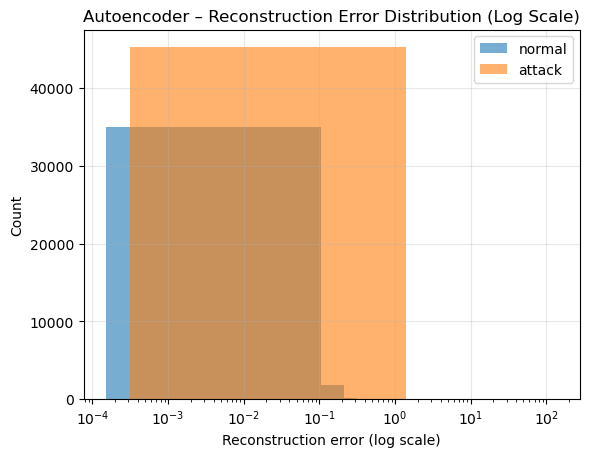

In [24]:
# Reconstruction error distribution graph (normal vs attack)
plt.figure()
plt.hist(reconstruction_error[y_te == 0], bins=100, alpha=0.6, label="normal")
plt.hist(reconstruction_error[y_te == 1], bins=100, alpha=0.6, label="attack")
plt.xscale("log")
plt.xlabel("Reconstruction error (log scale)")
plt.ylabel("Count")
plt.title("Autoencoder – Reconstruction Error Distribution (Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


4. Ablation Study for the MLP Model

This section examines how different engineered feature groups influence the 
performance of the MLP classifier. To evaluate the individual and combined 
contributions of these features, three controlled ablation scenarios were 
constructed:

• baseline_no_FE  
  In this baseline configuration, all engineered features are removed. Both the 
  byte_ratio feature and all flow-level statistical features (e.g., ct_* 
  variables, sload, dload, rate) are excluded to simulate a “no feature 
  engineering” setting.

• no_byte_ratio  
  Only the byte_ratio feature is removed, while flow-level statistical features 
  remain. This scenario isolates the contribution of the engineered byte-ratio 
  feature.

• no_flow_stats  
  All flow-level statistical features (ct_* variables, sload, dload, rate) are 
  removed, whereas byte_ratio is preserved. This scenario evaluates the impact 
  of the flow-statistics group.

For each scenario, the dataset is reprocessed with a scenario-specific 
preprocessing pipeline, a new MLP model is trained, and performance is evaluated 
on the test set using accuracy, precision, recall, F1-score, and ROC-AUC. The 
final results are summarized in a comparison table.



In [34]:
def make_preprocessor(df):
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]

    numeric = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler(with_mean=True)),
    ])

    categor = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    pre_local = ColumnTransformer(
        [
            ("num", numeric, num_cols),
            ("cat", categor, cat_cols),
        ],
        sparse_threshold=0.0,
    )
    return pre_local


In [35]:
flow_cols = [
    c for c in X_tr_raw.columns
    
    if c.startswith("ct_") or c in ["sload", "dload", "rate"]
]

print(flow_cols)


['rate', 'sload', 'dload', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']


In [36]:
cols_drop_base = ["byte_ratio"] + flow_cols

X_tr_base = X_tr_raw.copy().drop(columns=cols_drop_base, errors="ignore")
X_te_base = X_te_raw.copy().drop(columns=cols_drop_base, errors="ignore")

pre_base = make_preprocessor(X_tr_base)

X_tr_base_enc = pre_base.fit_transform(X_tr_base).astype("float32")
X_te_base_enc = pre_base.transform(X_te_base).astype("float32")

print(X_tr_base_enc.shape, X_te_base_enc.shape)


(175341, 181) (82332, 181)


In [37]:
X_tr_no_br = X_tr_raw.copy().drop(columns=["byte_ratio"], errors="ignore")
X_te_no_br = X_te_raw.copy().drop(columns=["byte_ratio"], errors="ignore")

pre_no_br = make_preprocessor(X_tr_no_br)


X_tr_no_br_enc = pre_no_br.fit_transform(X_tr_no_br).astype("float32")
X_te_no_br_enc = pre_no_br.transform(X_te_no_br).astype("float32")

print(X_tr_no_br_enc.shape, X_te_no_br_enc.shape)


(175341, 194) (82332, 194)


In [38]:
X_tr_no_fs = X_tr_raw.drop(columns=flow_cols, errors="ignore")
X_te_no_fs = X_te_raw.drop(columns=flow_cols, errors="ignore")

pre_no_fs = make_preprocessor(X_tr_no_fs)

X_tr_no_fs_enc = pre_no_fs.fit_transform(X_tr_no_fs).astype("float32")
X_te_no_fs_enc = pre_no_fs.transform(X_te_no_fs).astype("float32")

print(X_tr_no_fs_enc.shape, X_te_no_fs_enc.shape)


(175341, 182) (82332, 182)


In [39]:
results_ablation = {
    "baseline_no_FE": train_evaluate_mlp(X_tr_base_enc, y_tr, X_te_base_enc, y_te),
    "no_byte_ratio":  train_evaluate_mlp(X_tr_no_br_enc, y_tr, X_te_no_br_enc, y_te),
    "no_flow_stats":  train_evaluate_mlp(X_tr_no_fs_enc, y_tr, X_te_no_fs_enc, y_te),
}

results_ablation_df = pd.DataFrame(results_ablation).T
display(results_ablation_df)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 204us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 203us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step


,accuracy,precision,recall,f1,roc_auc
baseline_no_FE,0.822766,0.760173,0.990647,0.860241,0.972742
no_byte_ratio,0.882087,0.838502,0.973308,0.900890,0.979945
no_flow_stats,0.827540,0.767691,0.984779,0.862789,0.971899


In [40]:
full_results = train_evaluate_mlp(X_tr, y_tr, X_te, y_te)

results_ablation = {
    "full_FE":        full_results,
    "baseline_no_FE": train_evaluate_mlp(X_tr_base_enc, y_tr, X_te_base_enc, y_te),
    "no_byte_ratio":  train_evaluate_mlp(X_tr_no_br_enc, y_tr, X_te_no_br_enc, y_te),
    "no_flow_stats":  train_evaluate_mlp(X_tr_no_fs_enc, y_tr, X_te_no_fs_enc, y_te),
}

results_ablation_df = pd.DataFrame(results_ablation).T
display(results_ablation_df)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 202us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 200us/step


,accuracy,precision,recall,f1,roc_auc
full_FE,0.868605,0.821995,0.971808,0.890646,0.976430
baseline_no_FE,0.834038,0.776518,0.980874,0.866815,0.973501
no_byte_ratio,0.883873,0.848693,0.960293,0.901050,0.977588
no_flow_stats,0.834791,0.777002,0.981691,0.867435,0.972576
